 ## Predicción de Series Temporales. Master CD Cunef.
 ## Predicción Ingresos Apple (aapl).  ETS y ARIMA.

### Objetivos:
* Aplicar la estimación y selección de modelos ETS.
* Aplicar la estimación y selección de modelos ARIMA.
* Determinar la precisión de las predicciones.

### Objetivos Específicos: 
* Se debe elegir el modelo ETS y el Modelo ARIMA que mejor predice las ventas, habiendo dejado fuera de la estimación los últimos 8 trimestres.
* Una vez seleccionado el modelo se estimará el modelo con todos los datosy se harán las predicciones del resto del año 2021 y del 2022 (6 trimestres).
* Se realizará una comparación de las predicciones de los dos modelos.


## 0. Carga de librerias y lectura de datos.

In [1]:

import warnings
warnings.filterwarnings('ignore')
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.ets import AutoETS
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from pmdarima.arima import ADFTest, ndiffs
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.utils.plotting import plot_correlations
from sktime.transformations.series.difference import Differencer
from sktime.forecasting.arima import AutoARIMA
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rc("font", size=14)
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
#import datetime as dt

In [2]:
from pandas.tseries.offsets import DateOffset
# Read Data
aapl_df = pd.read_csv('aapl_ok.csv',sep=';',decimal=',')
aapl_df['fecha'] = pd.to_datetime(aapl_df['fecha'],format="%m/%d/%Y")
aapl_df['quater_fiscal']= aapl_df['fecha']+DateOffset(months=3)
aapl_df=aapl_df.set_index('quater_fiscal')
aapl_df = aapl_df.drop('Trimeste',axis=1)
#aapl_df = aapl_df.drop('fecha',axis=1)


In [3]:
# Transformamos la serie a periodos tirmesrales
aapl_ts=aapl_df.resample("q").first()
aapl_ts.index = aapl_ts.index.to_period('Q')
aapl_ts['quater_real']=aapl_ts['fecha'].dt.to_period('Q')
aapl_ts=aapl_ts.drop('fecha',axis=1)
aapl_ts=aapl_ts.reindex(columns=['quater_real','Ingresos'])
aapl_ts.tail(10)

,quater_real,Ingresos
quater_fiscal,,
2019Q2,2019Q1,58015.0
2019Q3,2019Q2,53809.0
2019Q4,2019Q3,64040.0
2020Q1,2019Q4,91819.0
2020Q2,2020Q1,58313.0
2020Q3,2020Q2,59685.0
2020Q4,2020Q3,64698.0
2021Q1,2020Q4,111439.0
2021Q2,2021Q1,89584.0


In [4]:
# Resamplemos la serie en la forma de sktime
# SKtime format
aapl_ts_q=aapl_df['Ingresos'].astype('float64').to_period('Q').sort_index()
aapl_ts_q.head()

quater_fiscal
1990Q1    1493.4
1990Q2    1346.2
1990Q3    1364.8
1990Q4    1354.1
1991Q1    1675.5
Freq: Q-DEC, Name: Ingresos, dtype: float64

## Exploración de datos.
### Gráfico.
La serie contiene los datos de ventas trimestrales de Apple por trimestres fiscales. Indicar que el ejercicio fiscal n, comienza en el 1-10- n-1 y termina en 30-09-n.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

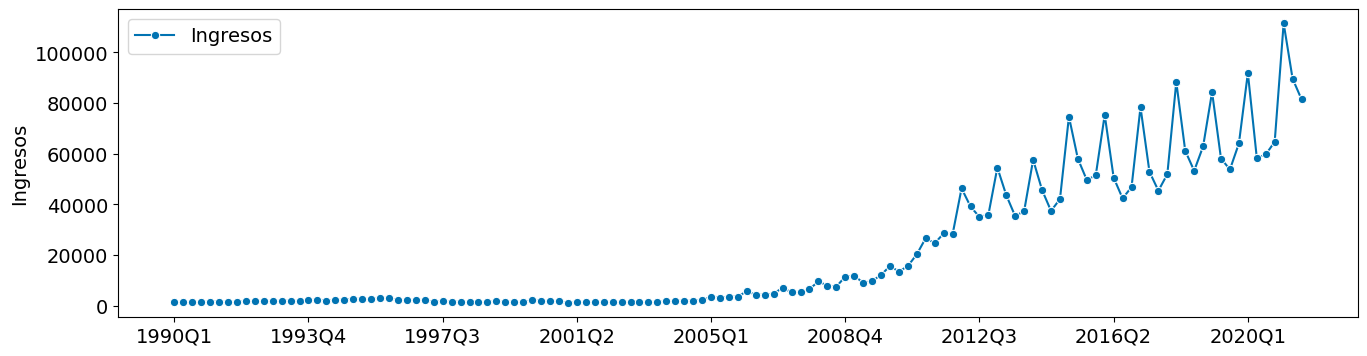

In [5]:

plot_series(aapl_ts_q,labels=['Ingresos'])

### Descomposición la serie.
De la descomposición de la serie determinamos que tiene tendiencia alcista y una marcada estacionalidad trimestral.
La amplitud de los errores en los últimos años nos puede indicar que la varianza de la serie va variando a lo largo del tiempo.

Text(0.5, 0, 'Año')

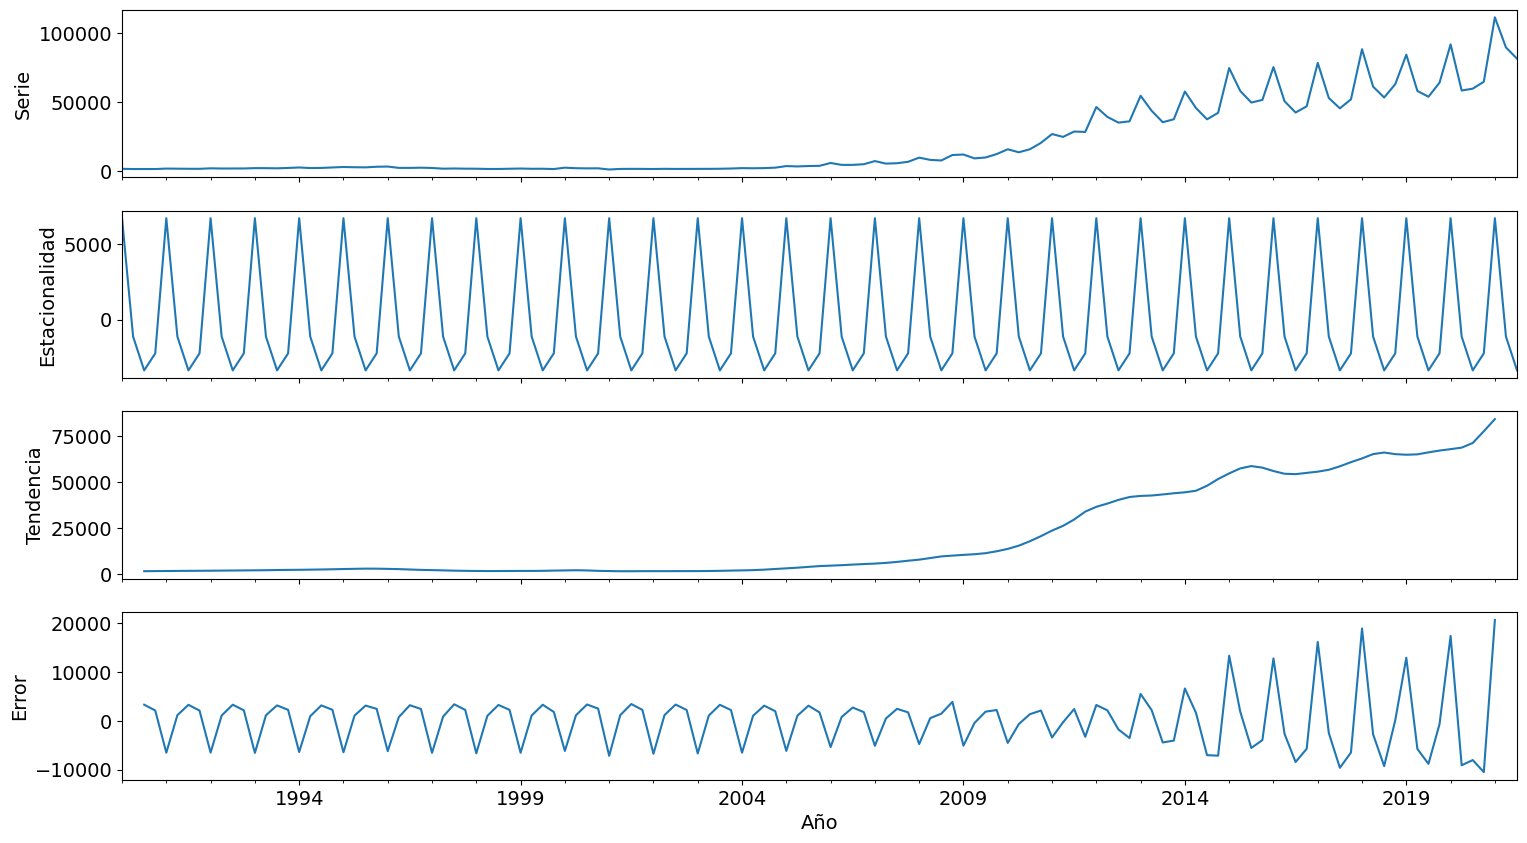

In [6]:
import matplotlib.dates as mdates

res = seasonal_decompose(aapl_ts_q, model='aditive',period=4)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(18,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Serie')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Estacionalidad')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Tendencia')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Error')

plt.xlabel("Año")

Text(0.5, 1.0, 'Comportamiento Estacional')

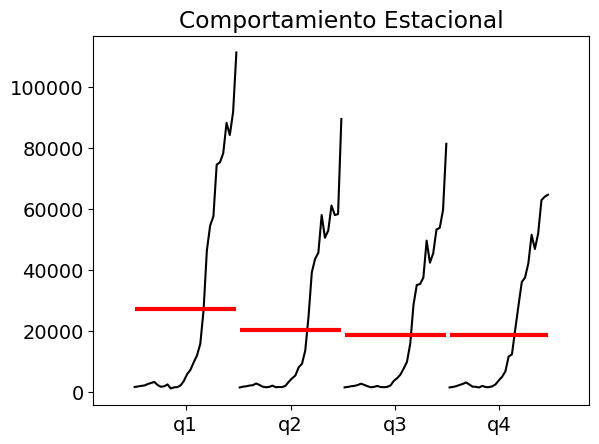

In [7]:
import statsmodels.api as sm
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

## Modelo ETS

In [8]:
# Dividimos en trsin y test, segun las especificaciones del caso.
y_train, y_test = temporal_train_test_split(y =aapl_ts_q, 
                                            test_size=8)

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

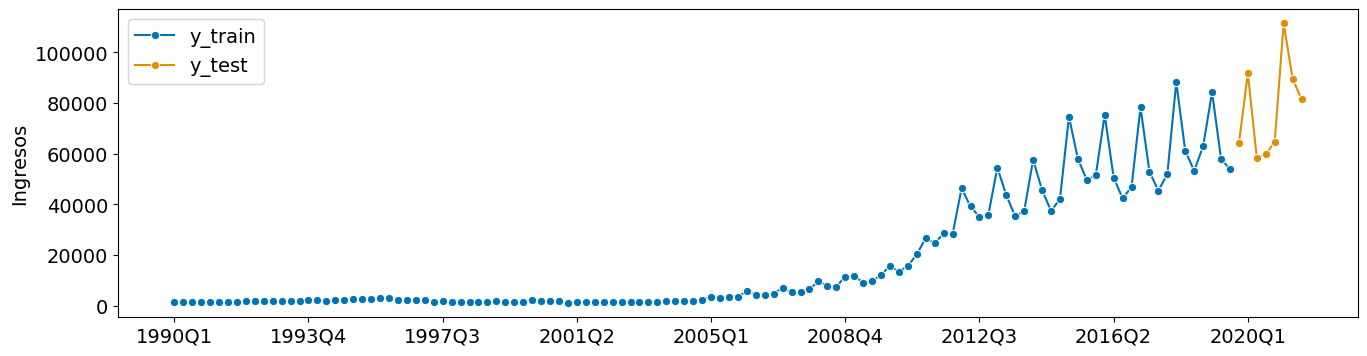

In [9]:
# Graficamos train y test.
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [10]:
# Visualizamos tamaño de los datasets.
print(y_train.shape[0], y_test.shape[0])

119 8


In [11]:
# Tipificamos horizonte de prediccioón: 8 de test.
fh_train = np.arange(1,9)
# Tipificamos el horizonte de predicción para los modelos con toda la serie, con 5 triestres necesarios para
# completar el 2022 real.
fh_all = np.arange(1,7)


In [12]:
# Buscamos el mejor modelo ETS.
aapl_autoets = AutoETS( auto=True, 
                          sp=4,
                          allow_multiplicative_trend=False,
                          n_jobs=-1)

In [13]:
aapl_autoets.fit(y_train)

AutoETS(auto=True, n_jobs=-1, sp=4)

In [14]:
aapl_autoets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Ingresos   No. Observations:                  119
Model:                       ETS(MAM)   Log Likelihood                -968.025
Date:                Sun, 06 Nov 2022   AIC                           1956.050
Time:                        21:02:43   BIC                           1983.841
Sample:                    03-31-1990   HQIC                          1967.335
                         - 09-30-2019   Scale                            0.018
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4225      0.055      7.739      0.000       0.316       0.530
smoothing_trend        0.1685      0.034      4.890      0.000       0.101       0.236
smoothing_seasonal     0.3568      0.077      4.646      0.000       0.206       0.507
initial_level       1370.9326    598.924      2.289      0.022     197.064    2544.802
initial_trend         46.0330     96.115      0.479      0.632    -142.349     234.415
initial_seasonal.0     0.8649      0.393      2.199      0.028       0.094       1.636
initial_seasonal.1     0.8891      0.402      2.210      0.027       0.101       1.678
initial_seasonal.2     0.9181      0.414      2.216      0.027       0.106       1.730
initial_seasonal.3     1.0000      0.441      2.265      0.024       0.135       1.865
===================================================================================
Ljung-Box (Q):                        5.15   Jarque-Bera (JB):               112.84
Prob(Q):                              0.74   Prob(JB):                         0.00
Heteroskedasticity (H):               1.20   Skew:                            -0.39
Prob(H) (two-sided):                  0.57   Kurtosis:                         7.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### El mejor modelo encontrado, es multiplicativo en los errores y en la estacionalidad, y aditivo en la tendencia.

In [15]:
# Generamos u nframe para ir guardando medidas de bondad de ajuste y de rendimiento de los diferentes modelos.
model_comparation=pd.DataFrame.from_dict(aapl_autoets.get_fitted_params(),orient='index',columns=['ETS_train'])

In [16]:
# Generamos y almacenamos predicciones.
aapl_autoets_pred_train= aapl_autoets.predict(fh_train)

In [17]:
aapl_autoets_pred_train

2019Q4    58581.326742
2020Q1    85963.040159
2020Q2    59751.798679
2020Q3    53079.526151
2020Q4    58323.465808
2021Q1    85584.234646
2021Q2    59488.205472
2021Q3    52845.108937
Freq: Q-DEC, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

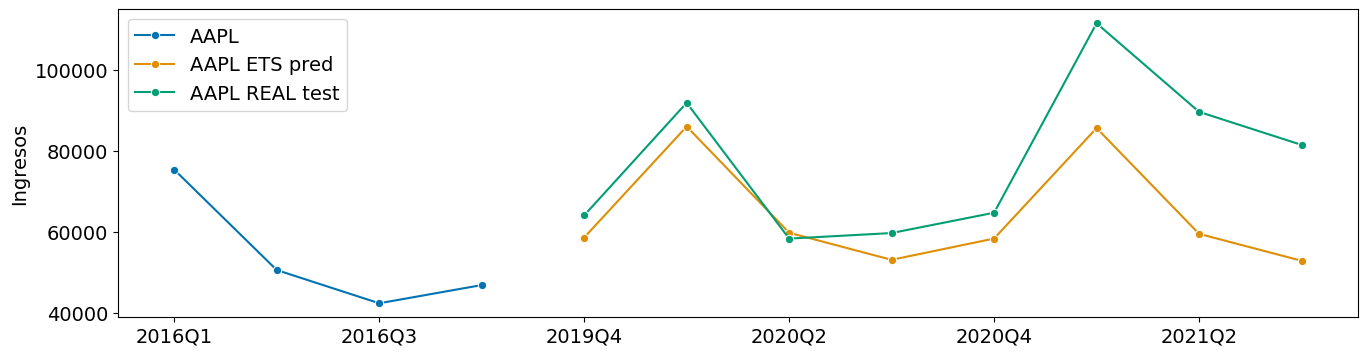

In [18]:
# Graficamos serie y predicción.
plot_series(y_train['2016'],aapl_autoets_pred_train ,y_test, labels=["AAPL", "AAPL ETS pred", "AAPL REAL test"])

In [19]:

# Calculamos MAPE Y RMSE del modelos en nuestro frame.
model_comparation.loc['MAPE','ETS_train']=mean_absolute_percentage_error(y_test,aapl_autoets_pred_train)

rmse=MeanSquaredError(square_root=True)
rmse_ets_train=rmse(y_test, aapl_autoets_pred_train)
model_comparation.loc['RMSE','ETS_train']=  rmse_ets_train
model_comparation

,ETS_train
aic,1956.049552
aicc,1958.086589
bic,1983.840787
hqic,1967.334695
MAPE,0.162740
RMSE,17825.462561


## Entrenamos el modelo ETS selecionado con toda la serie.

In [20]:
appl_autotest_all = aapl_autoets.fit(aapl_ts_q)

In [21]:
appl_autotest_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Ingresos   No. Observations:                  127
Model:                       ETS(MAM)   Log Likelihood               -1052.310
Date:                Sun, 06 Nov 2022   AIC                           2124.620
Time:                        21:02:44   BIC                           2153.062
Sample:                    03-31-1990   HQIC                          2136.176
                         - 09-30-2021   Scale                            0.018
Covariance Type:               approx                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.4303      0.055      7.816      0.000       0.322       0.538
smoothing_trend        0.1718      0.035      4.969      0.000       0.104       0.240
smoothing_seasonal     0.3322      0.075      4.430      0.000       0.185       0.479
initial_level       1370.9326    598.702      2.290      0.022     197.498    2544.367
initial_trend         46.0330     96.851      0.475      0.635    -143.792     235.858
initial_seasonal.0     0.8695      0.395      2.203      0.028       0.096       1.643
initial_seasonal.1     0.8897      0.402      2.213      0.027       0.102       1.678
initial_seasonal.2     0.9175      0.414      2.218      0.027       0.107       1.728
initial_seasonal.3     1.0000      0.442      2.265      0.024       0.135       1.865
===================================================================================
Ljung-Box (Q):                        5.73   Jarque-Bera (JB):               109.32
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.35
Prob(H) (two-sided):                  0.67   Kurtosis:                         7.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [22]:
# Alamacenamos las medidas de ajuste en el frame.
model_comparation.loc[['aic','aicc','bic','hqic'],'ETS_all'] = list(appl_autotest_all.get_fitted_params().values())

In [23]:
model_comparation

,ETS_train,ETS_all
aic,1956.049552,2124.620280
aicc,1958.086589,2126.516832
bic,1983.840787,2153.062151
hqic,1967.334695,2136.175869
MAPE,0.162740,NaN
RMSE,17825.462561,NaN


In [24]:
# Predecimos ocn el fh de los modelos all.
aapl_autoets_pred_all =  aapl_autoets.predict(fh_all)
aapl_autoets_pred_all

2021Q4     94928.198386
2022Q1    153907.759505
2022Q2    112068.409844
2022Q3    104446.057804
2022Q4    120404.562349
2023Q1    192615.706400
Freq: Q-DEC, dtype: float64

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

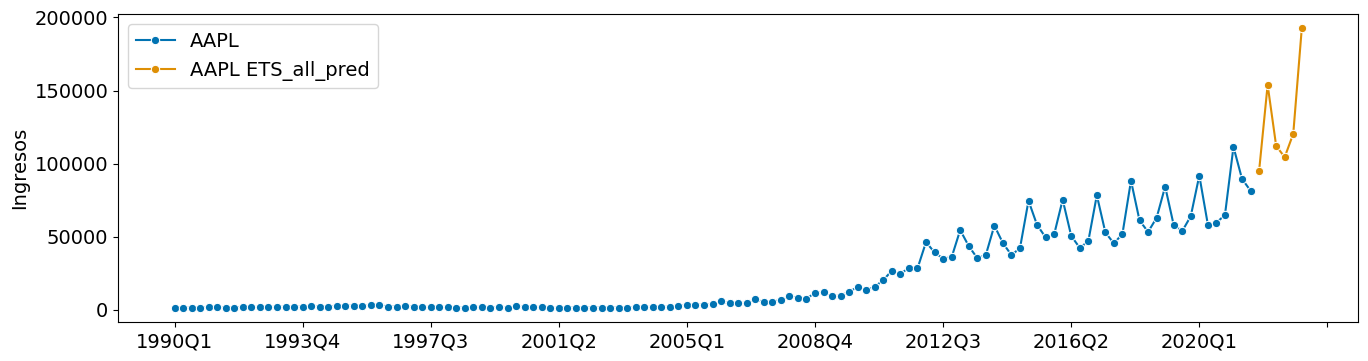

In [25]:
# Graficamos serie completa y preducción.
plot_series(aapl_ts_q,
            aapl_autoets_pred_all,
            labels=["AAPL",'AAPL ETS_all_pred'])

## Caracteristicas de la serie:

Del gráfico de la serie, observamos: 

Tendencia: No estacionaria.
Tiene componente estacional.
Varianza no constante.


## Tratamos la No estacionariedad en Varianza.
Vamos a aplicar la transformación boxcox, el transformador boxcox de sktime, encuentra el mejor parametro lamda para la transformación. De manera que ya sí el mejor lamda fuese 0, estaríamos aplicando la transformación logaritmica.
 

In [26]:
# Instanciamos un tranformador boxcox y se lo aplicamos a toda las serie.
trans_boxcox = BoxCoxTransformer()
boxcox_aapl_ts= trans_boxcox.fit_transform(aapl_ts_q)

boxcox_aapl_ts.tail()

2020Q3    3.896797
2020Q4    3.902638
2021Q1    3.939224
2021Q2    3.925101
2021Q3    3.918697
Freq: Q-DEC, dtype: float64

Text(0.5, 1.0, 'Ingresos Apple: Transformación boxcox')

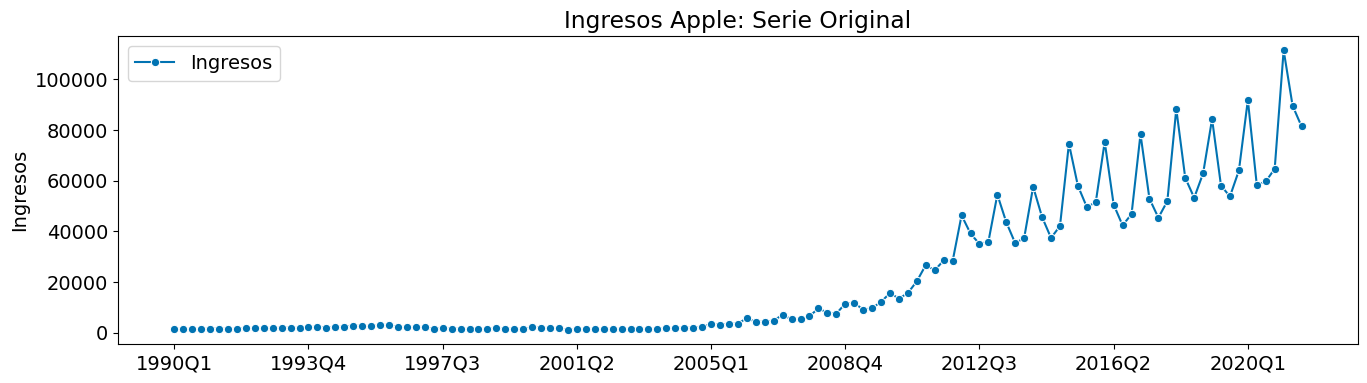

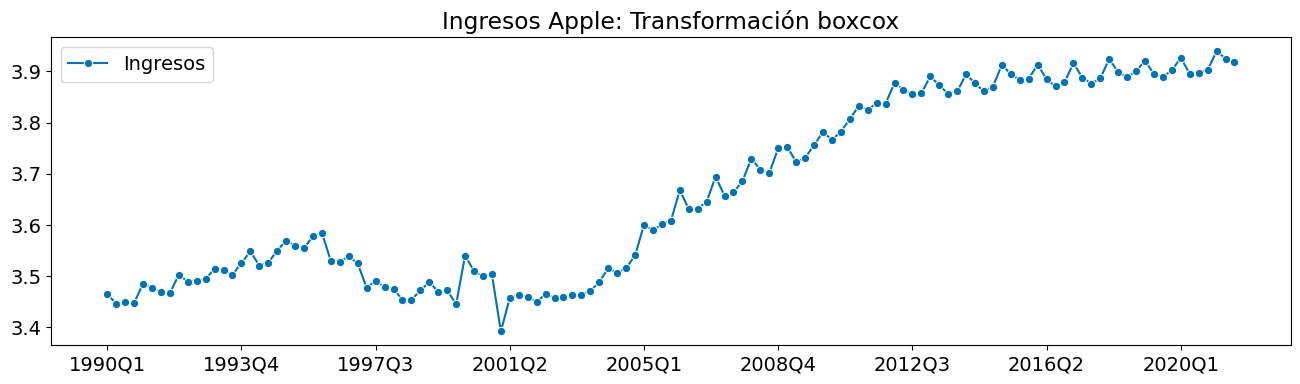

In [27]:
# Graficamos comparado la serie original y transformada.
fig, ax =plot_series(aapl_ts_q, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Serie Original')
fig, ax =plot_series(boxcox_aapl_ts, labels=["Ingresos"])
ax.set_title('Ingresos Apple: Transformación boxcox')

## Autocorrelacion.
La serie sin diferenciación presenta autocorrelación muy clara.
Aplicamos un operador de diferenciación con retardo y parece que correguimos la autocorrelación. Probamos con 1 y 4 retardos, parece que ofrece peor correción que solo con retardo 1.
No se observan signos de estacionalidad, al haber aplicado boxcox.

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

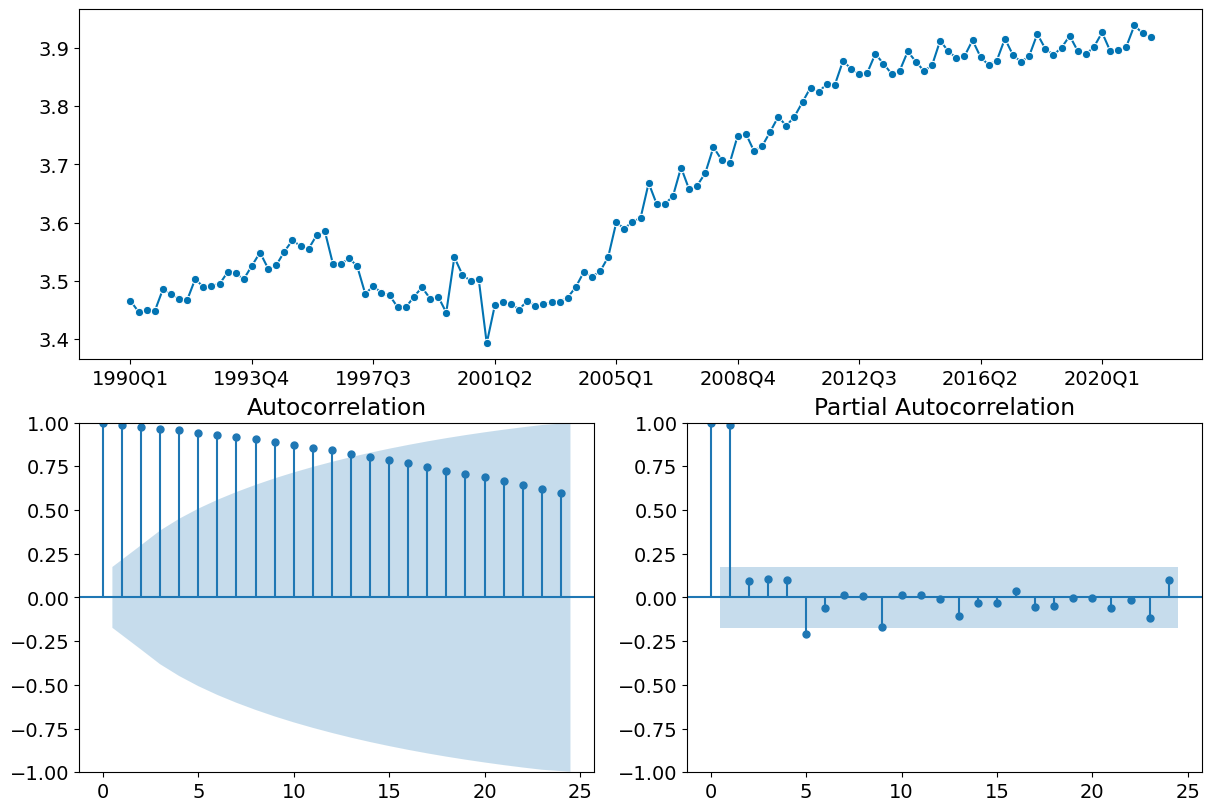

In [28]:
plot_correlations(boxcox_aapl_ts,alpha=0.05)

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

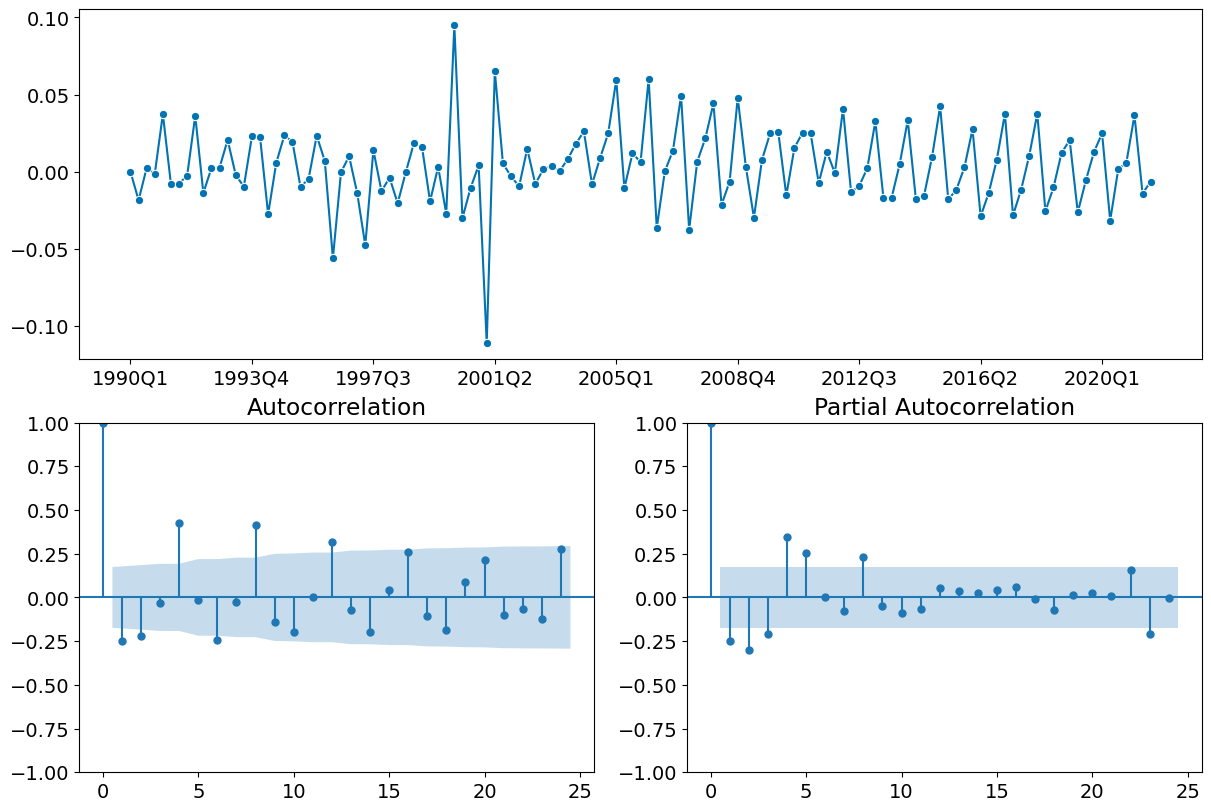

In [29]:
# Instanciamos un operador diff con un retardo de 1, y transformamos la serie original.
trans_diff= Differencer(lags=[1])
plot_correlations(trans_diff.fit_transform(boxcox_aapl_ts),alpha=0.05)

(<Figure size 1200x800 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

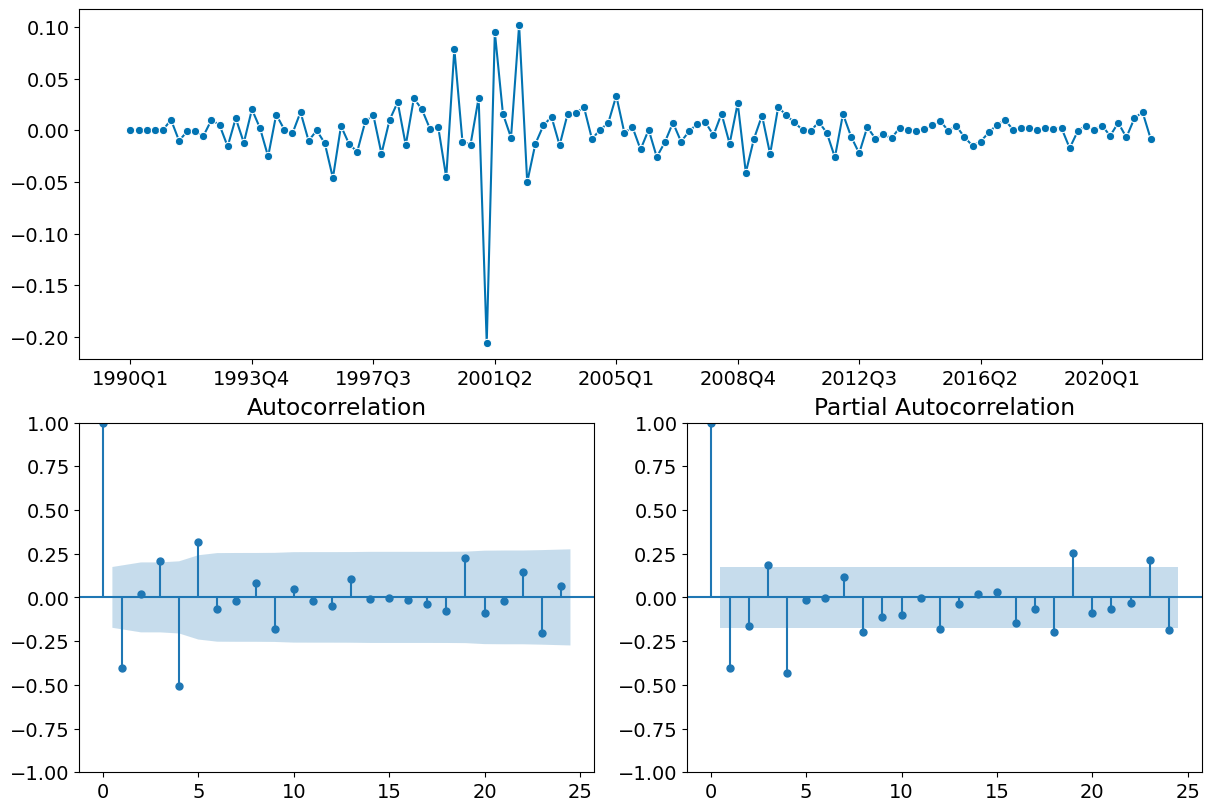

In [30]:
trans_diff= Differencer(lags=[1,4])
plot_correlations(trans_diff.fit_transform(boxcox_aapl_ts),alpha=0.05)

## Test Dickey-Fuller Aumentado
Aplicamos el Test de Dickey-Fuller Aumentado para ver sí la serie es estacionaria, el resultado es que es una serie no estacionaria y que debemos, por lo menos, aplicar diferencias. Nos está dando el resultado de que la serie es no estacionaria con un 60 % de posibilidades y que necesita calcular diferencias.
Tambien nos indica que con un retaro de 1 se solucionaría.
Aplicamos un retardo de 1, y el test nos confirma que hemos conseguido transformarla en ESTACIONARIA.


In [31]:
adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(boxcox_aapl_ts))
print(ndiffs(aapl_ts_q))

(0.5999956972865687, True)
1


In [32]:
adf_test.should_diff(trans_diff.fit_transform(boxcox_aapl_ts))

(0.01, False)

 # Modelos ARIMA


Vamos a separar la muestra en la parte de estiamción (Training) y la parte de predicción/Verificación (Testing). Quitamos 8 trimestres.

 Vamos a predecir 8 periodos(h=8).


119 8
119 8


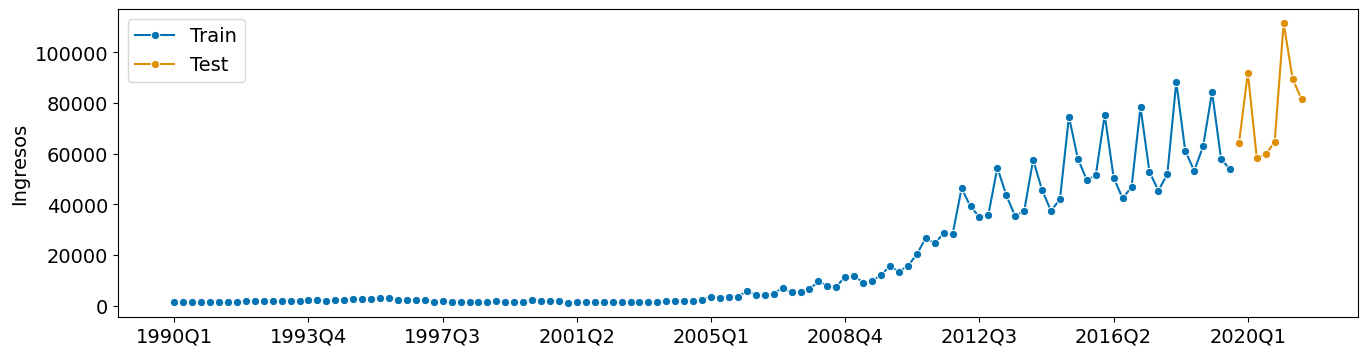

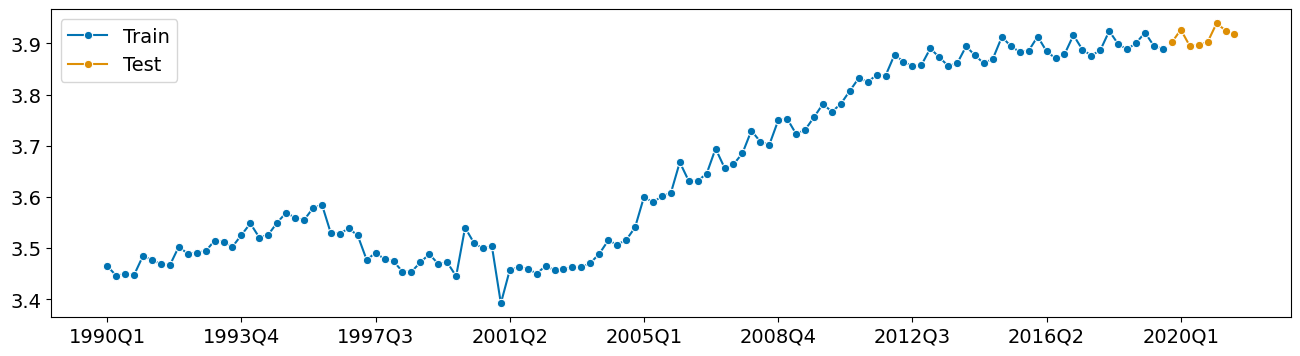

In [33]:
# Seleccionamos train y test. Para serie original y transformada por boxcox.
# Revisamos forma y graficamos.
y_train, y_test = temporal_train_test_split(y =aapl_ts_q, test_size=8)
boxcox_y_train, boxcox_y_test = temporal_train_test_split(y =boxcox_aapl_ts, test_size=8)
plot_series(y_train, y_test, labels=["Train", "Test"])
plot_series(boxcox_y_train,boxcox_y_test , labels=["Train", "Test"])


print(y_train.shape[0], y_test.shape[0])
print(boxcox_y_train.shape[0], boxcox_y_test.shape[0])

In [34]:
#  Utilizamos la función AutoARIMA, para que buscar el mejor modelo ARIMA en téminos de AIC.

aapl_arima_train = AutoARIMA(sp=4,suppress_warnings=True)
aapl_arima_train.fit(boxcox_y_train)

AutoARIMA(sp=4, suppress_warnings=True)

In [35]:
#  Auto ARIMA Model Summary
print(aapl_arima_train.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(2, 0, 1, 4)   Log Likelihood                 286.150
Date:                           Sun, 06 Nov 2022   AIC                           -562.301
Time:                                   21:03:13   BIC                           -548.447
Sample:                               03-31-1990   HQIC                          -556.676
                                    - 09-30-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3575      0.076     -4.721      0.000      -0.506      -0.209
ar.S.L4        1.2365      0.120     10.299

El modelo encontrado es un modelo SARIMAX, con parámetros:
- Orden del Modelo Autoregresivo. P = 0
- Número de diferenciaciones aplicadas a la serie original. d=1
- Orden del modelo de media movil (MA). q= 1.
- Orden del Modelo Autoregresivo Estacional. P= 2
- Número de diferenciaciones aplicadas a la serie original de manera Estacional. D=0
- Orden del modelo media movil estacional. Q=1.
- Número de pasos de tiempo que mide la estación de la serie. S=4.



In [36]:
# Alamacenamos los datos de rendimiento en nuestro frame de comparaciones.
model_comparation.loc[['aic','aicc','bic','hqic'],
                      'ARIMA_train'] =  [aapl_arima_train.get_fitted_params()[x] 
                                        for x in ['aic','aicc','bic','hqic']]

In [37]:
model_comparation

,ETS_train,ETS_all,ARIMA_train
aic,1956.049552,2124.620280,-562.300774
aicc,1958.086589,2126.516832,-561.765060
bic,1983.840787,2153.062151,-548.447351
hqic,1967.334695,2136.175869,-556.675876
MAPE,0.162740,NaN,NaN
RMSE,17825.462561,NaN,NaN


In [38]:
#  Predecimos con el fh de train.
boxcox_arima_pred_train = aapl_arima_train.predict(fh_train)
boxcox_arima_pred_train

2019Q4    3.900469
2020Q1    3.921959
2020Q2    3.903837
2020Q3    3.900592
2020Q4    3.909932
2021Q1    3.931536
2021Q2    3.915529
2021Q3    3.912876
Freq: Q-DEC, dtype: float64

In [39]:
# Realizamos la transformación inversa para la transformación boxcox.
real_aapl_pred_train=trans_boxcox.inverse_transform(boxcox_arima_pred_train)
real_aapl_pred_train

2019Q4    62777.323206
2020Q1    85465.396733
2020Q2    65790.352833
2020Q3    62884.706119
2020Q4    71712.328505
2021Q1    98813.958063
2021Q2    77742.535602
2021Q3    74809.556170
Freq: Q-DEC, dtype: float64

In [40]:
# Calculamos el MAPE de la predicción sin boxcox, alamcenamos en comparador.

model_comparation.loc['MAPE','ARIMA_train']= mean_absolute_percentage_error(y_test, real_aapl_pred_train)
mean_absolute_percentage_error(y_test, real_aapl_pred_train)

0.08824869272775573

In [41]:
# Calculamos el RMSE de la predicción sin boxcox, almacenmos.

model_comparation.loc['RMSE','ARIMA_train']=rmse(y_test, real_aapl_pred_train)
rmse(y_test, real_aapl_pred_train)

7912.076017270491

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

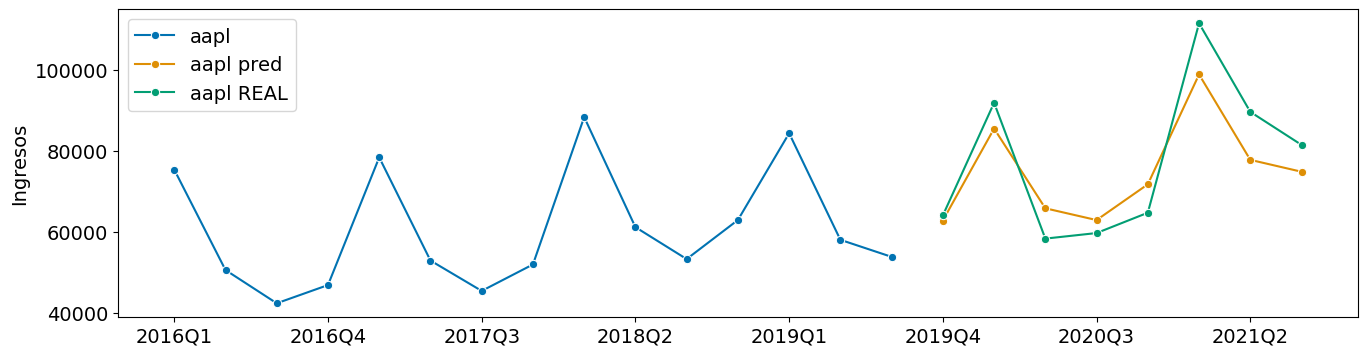

In [42]:
# Grafimamos serie y predicciones.
plot_series(y_train["2016":],  real_aapl_pred_train,y_test, labels=["aapl", "aapl pred", "aapl REAL"])

## Aplicamos el modelo ARIMA seleccioando a toda la serie.

In [43]:
#  Auto ARIMA Model
aapl_arima_all= aapl_arima_train.fit(boxcox_aapl_ts)

In [44]:

aapl_arima_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 4)   Log Likelihood                 308.710
Date:                             Sun, 06 Nov 2022   AIC                           -605.419
Time:                                     21:03:38   BIC                           -588.402
Sample:                                 03-31-1990   HQIC                          -598.506
                                      - 09-30-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3905      0.078     -5.035      0.000      -0.543      -0.239
ma.L2         -0.0462      0.139     -0.334      0.739      -0.318       0.225
ma.L3          0.2206      0.090      2.455      0.014       0.044       0.397
ar.S.L4        0.9692      0.043     22.663      0.000       0.885       1.053
ma.S.L4       -0.8427      0.113     -7.449      0.000      -1.064      -0.621
sigma2         0.0004   3.04e-05     13.965      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):              1451.44
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                            -1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#  Inveretimos la transfrormación boxcox.
boxcox_y_pred_all = aapl_arima_all.predict(fh_all)
aapl_arima_pred_all = trans_boxcox.inverse_transform(boxcox_y_pred_all)
aapl_arima_pred_all

2021Q4     93931.763239
2022Q1    144222.473966
2022Q2    109436.443429
2022Q3    102092.460817
2022Q4    115825.191941
2023Q1    174205.441210
Freq: Q-DEC, dtype: float64

In [46]:
# Alamacensmos las medidas de bondad de ajuste en nuestro comaprador.
model_comparation.loc[['aic','aicc','bic','hqic'],
                      'ARIMA_all'] =  [aapl_arima_all.get_fitted_params()[x] 
                                        for x in ['aic','aicc','bic','hqic']]

In [47]:
model_comparation

,ETS_train,ETS_all,ARIMA_train,ARIMA_all
aic,1956.049552,2124.620280,-562.300774,-605.419453
aicc,1958.086589,2126.516832,-561.765060,-604.713570
bic,1983.840787,2153.062151,-548.447351,-588.401761
hqic,1967.334695,2136.175869,-556.675876,-598.505698
MAPE,0.162740,NaN,0.088249,NaN
RMSE,17825.462561,NaN,7912.076017,NaN


### Sección 3. Preguntas a Resolver


####  ¿Los ingresos de Apple son estacionarios? ¿En media? ¿En varianza? ¿Cuál es su tendencia? ¿y su componente estacional?
Para la confección de los modelos hemos analizado la serie de manera exahustiva, es una serie claramente no estacioanria en media y en varianza.
La tendiencia es creciente a partir de apox año 2.000, coincidiendo con el lanzamiento del Ipod y se porduce una explosión a partir de 2.007 con el lanzamiento del Iphone y lo que supuso para la empresa.

Analizando la estacionalidad, la media de ingresos por trimestre de todos laos años  es creciente del 1 al cuarto trimestre de fecha reales. Viene a confirmar que los productos Apple (precio caro) se utilizan como regalo navideño, y seguramente la importancia actual del black-Friday lo refuerza. Repasando los releases ( lanzamientos) importantes, se suelen producir en el mes de septiembre, lo que refuerza esta fuerza del cuarto trimestre.

La existencia de estacionalidad nos confirma la no-estacionaridad en varianza,y por ello, hemos aplicado la tranción de boxcox para elimimarla en los modelos arima.


Text(0.5, 0, 'Año')

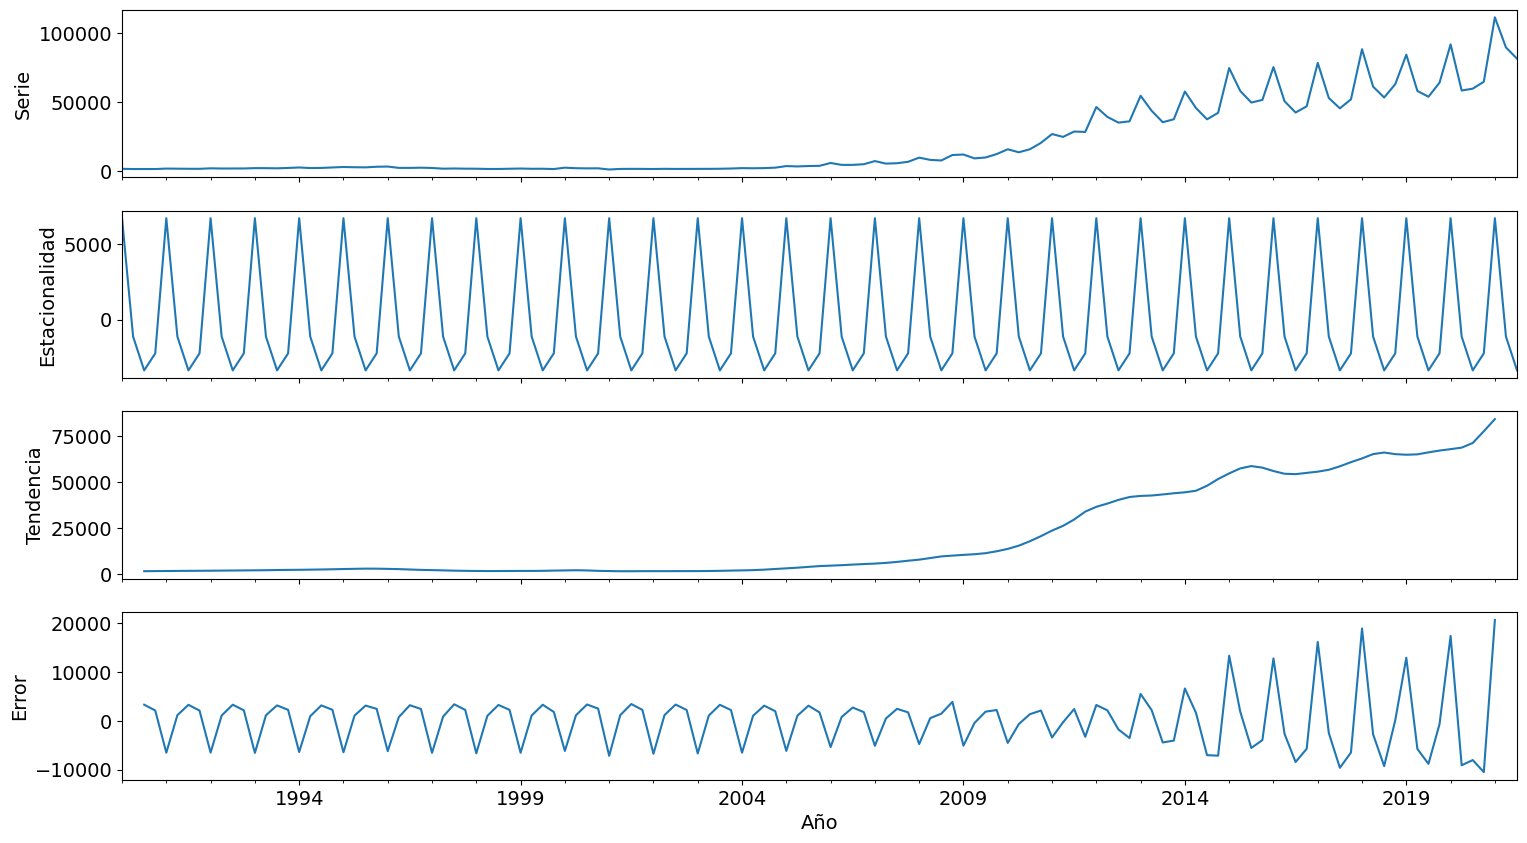

In [48]:
import matplotlib.dates as mdates

res = seasonal_decompose(aapl_ts['Ingresos'], model='aditive',period=4)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(18,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Serie')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Estacionalidad')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Tendencia')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Error')

plt.xlabel("Año")

Text(0.5, 1.0, 'Comportamiento Estacional')

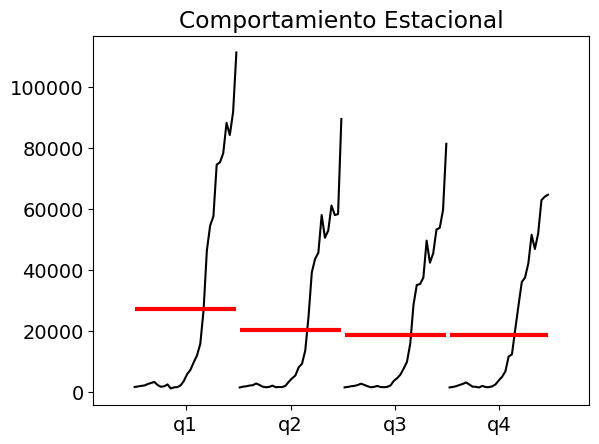

In [49]:
ax = plt.gca()
sm.graphics.tsa.quarter_plot(aapl_ts['Ingresos'],ax=ax)
ax.set_title('Comportamiento Estacional')

In [50]:
adf_test = ADFTest(alpha=0.05)
print(adf_test.should_diff(aapl_ts_q))
print(ndiffs(aapl_ts_q))

(0.99, True)
1


#### ¿Cuales son las ventas anuales de Apple?

Vamos a utilizar cuatrimestres reales contestar esta pregunta. Se muestran los 11 últimos años. Para el año 2021 solo están computados 2 trimestres.

In [51]:
# Operamos sobre la serie para pasar el trimestre real ala indice y agrupamos por años.
aapl_year_income= aapl_ts.reset_index(drop=True).set_index('quater_real').resample('Y').sum()
aapl_year_income.tail(11)

,Ingresos
quater_real,
2011,127841.0
2012,164687.0
2013,173992.0
2014,199800.0
2015,234440.0
2016,218118.0
2017,238536.0
2018,261612.0
2019,267683.0


#### ¿Cuales son los crecimientos anuales de los ingresos?

Recordamos que en el año 2.021 solo están computados dos trimestres.

In [52]:
# Generamos una columna con pyc_change, que calcula cambios porcentuales.
aapl_year_income['perc_change']=aapl_year_income.pct_change(fill_method='ffill')*100
aapl_year_income.tail(11).style.format({'Ingresos': "{:,}",'perc_change':"{:.2f}"})

,Ingresos,perc_change
quater_real,,
2011,"127,841.0",67.59
2012,"164,687.0",28.82
2013,"173,992.0",5.65
2014,"199,800.0",14.83
2015,"234,440.0",17.34
2016,"218,118.0",-6.96
2017,"238,536.0",9.36
2018,"261,612.0",9.67
2019,"267,683.0",2.32


#### ¿Qué modelo predice mejor?
Comparamos los modelos de train y los meodelos completos ( _all), por separado.
En train, ARIMA supera tanto en medidas de ajuste, tanto el aic como bic son inferiores. COmo en medidas de rendimientos, tanto la MAPE como RSME la mitad en el caso de ARIMA.
En los modelos completos, solo podemso comparar el ajuste, y ARIMA es claramente superior en todas las medidas de ajuste.

(<Figure size 1600x400 with 1 Axes>, <AxesSubplot: ylabel='Ingresos'>)

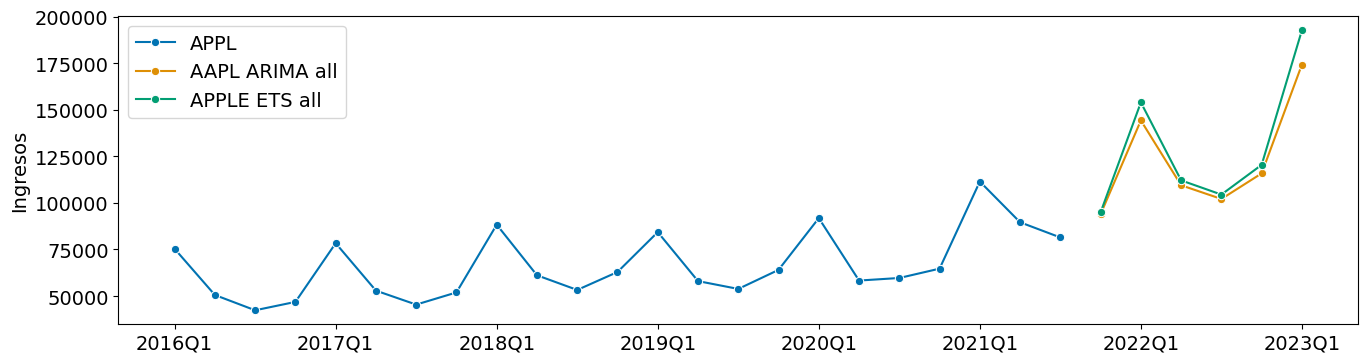

In [53]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(aapl_ts_q["2016":],aapl_arima_pred_all ,aapl_autoets_pred_all, 
            labels=["APPL", "AAPL ARIMA all",'APPLE ETS all'])

In [54]:
model_comparation.loc[:,['ETS_train','ARIMA_train']].round(2)

,ETS_train,ARIMA_train
aic,1956.05,-562.30
aicc,1958.09,-561.77
bic,1983.84,-548.45
hqic,1967.33,-556.68
MAPE,0.16,0.09
RMSE,17825.46,7912.08


In [55]:
model_comparation.loc[['aic','aicc','bic','hqic'],['ETS_all','ARIMA_all']].round(2)

,ETS_all,ARIMA_all
aic,2124.62,-605.42
aicc,2126.52,-604.71
bic,2153.06,-588.40
hqic,2136.18,-598.51


#### ¿Existe efecto COVID? Cuantificar.

Para cuantificar el efecto covid, años 2.020 y 2.21, contruimos una tabla con los cremientos de lso primeros semestres de todos los años.
Los ingresos en el primer tirmestre del año 2.020 crecieron un 5,52 con respecto a los ingresos del primer semestre del 2.019. 
Realiando esta misma comparación para los primeros semestres desde del año 2.011, se observa mucha variabilidad en los cremientos, desde el 82 % e cremiento del 1 semestre 2.011 en relación a 1 semestre 2.010, hasta caidas del 13 % del 1 semestre 2.016 frente a 1 semestre 2.015.

De manera, que no detectamos un efecto covid en el primer semestre de 2.020.

Con respecto a la evolución de 1 semestre 2.021 con respecto a 1 semestre 2.020, el cremiento es del 44.93 %, el segundo mejor de los últimos 11 años.

In [56]:
# Generamos un frame borrando la primera fila con indice trimestre real.
aapl_semester_income= aapl_ts.iloc[1:].reset_index(drop=True).set_index('quater_real')
# Cambiamos el dtype del indice a Datetime para facilitar operaciones.
aapl_semester_income.index=  aapl_semester_income.index.astype('datetime64[ns]')
# Resampleamos por semestre (2Q), para comparar el primer semestre 2.020.
aapl_semester_income= aapl_semester_income.resample('2Q',kind='period').sum()
# Volvemos a poner indice a datetime para facilitar la operación de filtrado de 1 semestres.
aapl_semester_income.index=  aapl_semester_income.index.astype('datetime64[ns]')
# Filtramos solo los datos correspondientes a los primeros semestres de cada año.
aapl_1_semester_income=aapl_semester_income.loc[aapl_semester_income.index.month==1]
# Calculamos incrementos porcentuales de 1 semestre aos n frente a primer triemstre n-1.
aapl_1_semester_income['perc_change']=aapl_1_semester_income.pct_change(fill_method='ffill')*100
# Volvemos a poner el indice comp periodindex.
aapl_1_semester_income.index = aapl_1_semester_income.index.to_period('2Q')

aapl_1_semester_income.tail(11).style.format({'Ingresos': "{:,}",'perc_change':"{:.2f}"})

,Ingresos,perc_change
quater_real,,
2011Q1,"53,238.0",82.33
2012Q1,"74,209.0",39.39
2013Q1,"78,926.0",6.36
2014Q1,"83,078.0",5.26
2015Q1,"107,615.0",29.53
2016Q1,"92,915.0",-13.66
2017Q1,"98,304.0",5.80
2018Q1,"114,402.0",16.38
2019Q1,"111,824.0",-2.25


<AxesSubplot: xlabel='quater_real'>

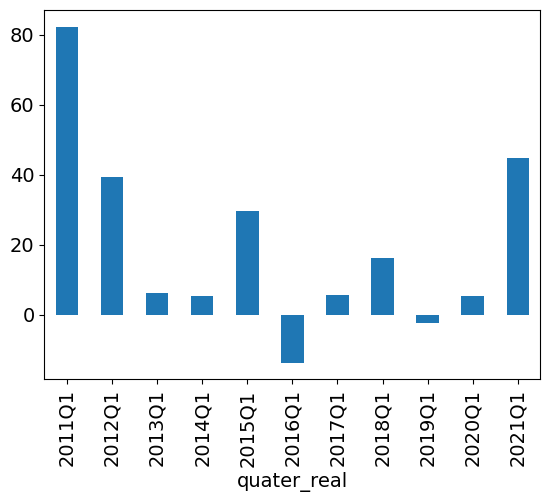

In [57]:
# Graficamos.
aapl_1_semester_income.perc_change.tail(11).plot(kind='bar')

#### ¿Cuales son las ventas acumuladas para el año 2021? ¿Y para el 2022?

Generamos un tabla, donde para el primer y segundo trimestre de 2.021 utilizamos datos reales, ya conocidos.
Para el resto de 2.021 y todo 2.022 utilizamos las previsioens de nuestros modelos, y los presentsmos agrupados por años.

In [58]:
## Generamos uan funcion ara guardar las predicciones con fecha fiscales y reales para un modelo all.

def predictions_frame(model,fh,model_name):

    model_pred= model.predict(fh).to_frame().rename(columns={0: model_name})
    model_pred.index.name='trimestre_fiscal'
    model_pred['trimestre_real']=model_pred.index.to_timestamp()+DateOffset(months=-3)
    model_pred['trimestre_real']=model_pred['trimestre_real'].dt.to_period('Q')
    model_pred=model_pred.reindex(columns=['trimestre_real',model_name])
    #model_pred=model_pred.reset_index().set_index('trimestre_real')
    return model_pred

In [59]:
# Generamos un frame con las prediccioens del modelo autotest_all.
predicciones_modelos_all= predictions_frame(appl_autotest_all,fh_all,'ETS_all')
# Añadimos las prediccioens de arima_all.
predicciones_modelos_all['ARIMA']=aapl_arima_pred_all.to_list()
# Cambiamos el indice a cuatrimestre real.
predicciones_modelos_all = predicciones_modelos_all.reset_index(drop=True).set_index('trimestre_real')

# Añadimos los datos reales del primer y segundo trimetre de 2.021.
predicciones_modelos_all.loc[pd.to_datetime('2021-01-01').to_period('Q'),:]=89584.0
predicciones_modelos_all.loc[pd.to_datetime('2021-04-01').to_period('Q'),:]=81434.0
# Ordenmos por el indice.
predicciones_modelos_all = predicciones_modelos_all.sort_index()
# Resampleamso por año.
predicciones_modelos_all=predicciones_modelos_all.resample('Y').sum()
# Presentamos salida.
predicciones_modelos_all.style.format({'ETS_all': "{:,.0f}",'ARIMA': "{:,.0f}"})

,ETS_all,ARIMA
trimestre_real,,
2021,"419,854","409,172"
2022,"529,535","501,560"


#### ¿Son creíbles las predicciones del Barclays?

In [60]:
#  Repite un proceso similar a predicciones_modelos_al
predicciones_modelos_b= predictions_frame(appl_autotest_all,fh_all,'ETS_all')
predicciones_modelos_b=predicciones_modelos_b.drop('trimestre_real',axis=1)
predicciones_modelos_b['ARIMA']=aapl_arima_pred_all.to_list()
predicciones_modelos_b.loc[pd.to_datetime('2021-01-01').to_period('Q'),:]=111439.0
predicciones_modelos_b.loc[pd.to_datetime('2021-04-01').to_period('Q'),:]=89584.0
predicciones_modelos_b.loc[pd.to_datetime('2021-07-01').to_period('Q'),:]=81434.0
predicciones_modelos_b = predicciones_modelos_b.sort_index()
predicciones_modelos_b=predicciones_modelos_b.iloc[:-1 , :]

predicciones_modelos_b=predicciones_modelos_b.resample('Y').sum()
predicciones_modelos_b['BARCLAYS']=[368925, 378619]
predicciones_modelos_b.style.format({'ETS_all': "{:,.0f}",'ARIMA': "{:,.0f}",'BARCLAYS': "{:,.0f}" })

,ETS_all,ARIMA,BARCLAYS
trimestre_fiscal,,,
2021,"377,385","376,389","368,925"
2022,"490,827","471,577","378,619"


Primero, indicar que para el año fiscal 2.021 tanto Barckays como nuestros modelos solo están estimando el 4 trimestre, ya que tres trimestres ya se conocen. Para el año 2.022, se estiman los 4 trimestres.
Según nuestros modelos parece que Barkclays está haciendo estiamcioens muy prudentes, ya que son sensiblemte inferiores a las que ofrecen nuestros modelos. La metologia es completemente diferente, ya que ellos utilizan la prevsion de ingresos disgreagos por lienas de producto, dato que nosotros no tenemos.

Como Apple ya cerró los dos años años fiscales, ya podemos saber lo que ocurrió y que previsiones eran mas acertadas. Sin duda, eran las de Barckalys.

In [61]:
predicciones_modelos_b['aapl_real'] = [365817,394328]
predicciones_modelos_b.style.format({'ETS_all': "{:,.0f}",'ARIMA': "{:,.0f}",'BARCLAYS':"{:,.0f}",'aapl_real':"{:,.0f}" })

,ETS_all,ARIMA,BARCLAYS,aapl_real
trimestre_fiscal,,,,
2021,"377,385","376,389","368,925","365,817"
2022,"490,827","471,577","378,619","394,328"
